In [2]:
# ======================
# CELL 0: DATA SPLITTING
# ======================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("🔧 CREATING DATA SPLITS...")

# Assuming you have X and y defined from your previous work
# If not, let's recreate them:

# Your feature columns (from your previous definition)
feature_columns = [
    # Environmental features
    'avg_traffic_pct', 'avg_diesel_pm', 'avg_cancer_risk', 
    'avg_resp_hazard', 'avg_ej_index',
    
    # Socioeconomic features  
    'median_household_income', 'poverty_rate', 'educational_attainment',
    'income_distribution', 'homeownership_rate', 
    'health_insurance_coverage_pop',
    'total_housing_population', 'total_ownership_population',
    
    # Demographic features
    'race_ethnicity_minority_status', 'white_population', 'black_population',
    'asian_population', 'hispanic_population', 'total_race_population',
    
    # Vulnerability features
    'svi_score', 'socioeconomic_status', 'household_characterisitcs',
    'housing_type_transportation'
]

# Make sure df is loaded (replace with your actual data loading)
df = pd.read_csv("master_data.csv")

# Create feature matrix X and target vector y
X = df[feature_columns]
y = df['High_Risk']

print(f"Dataset: {X.shape[0]} ZIP codes, {X.shape[1]} features")
print(f"High-risk ZIPs: {y.sum()}/{len(y)} ({y.mean():.1%})")

# Your exact splitting strategy
# First split: 70% training, 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Keep same high-risk ratio in all splits
)

# Second split: Split 30% into 20% test + 10% validation
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.333,  # 10% of original data
    random_state=42,
    stratify=y_temp
)

print("Data Splitting:")
print(f"Training: {X_train.shape[0]} samples ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({(X_val.shape[0]/len(X))*100:.1f}%)")  
print(f"Test: {X_test.shape[0]} samples ({(X_test.shape[0]/len(X))*100:.1f}%)")

print(f"\nHigh-risk distribution across splits:")
print(f"Training: {y_train.mean():.3f} ({y_train.sum()}/{len(y_train)})")
print(f"Test: {y_test.mean():.3f} ({y_test.sum()}/{len(y_test)})")
print(f"Validation: {y_val.mean():.3f} ({y_val.sum()}/{len(y_val)})")

print("✅ Data splits created successfully!")

🔧 CREATING DATA SPLITS...
Dataset: 1170 ZIP codes, 23 features
High-risk ZIPs: 686/1170 (58.6%)
Data Splitting:
Training: 819 samples (70.0%)
Validation: 117 samples (10.0%)
Test: 234 samples (20.0%)

High-risk distribution across splits:
Training: 0.586 (480/819)
Test: 0.585 (137/234)
Validation: 0.590 (69/117)
✅ Data splits created successfully!


In [3]:
# ======================
# CELL 1: IMPORTS AND DATA PREPARATION
# ======================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 ATTEMPT 2: COMPREHENSIVE 4-MODEL ANALYSIS")
print("=" * 60)

# Data preparation using your existing splits
print("1. Preparing data using your existing splits...")

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrames
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

print(f"Training set: {X_train_imputed.shape}")
print(f"Validation set: {X_val_imputed.shape}")
print(f"Test set: {X_test_imputed.shape}")
print("✅ Data preparation complete!")

🚀 ATTEMPT 2: COMPREHENSIVE 4-MODEL ANALYSIS
1. Preparing data using your existing splits...
Training set: (819, 23)
Validation set: (117, 23)
Test set: (234, 23)
✅ Data preparation complete!


In [4]:
# ======================
# CELL 2: MODEL INITIALIZATION
# ======================

print("\n2. Initializing all 4 models...")

models = {
    'Random Forest Classifier': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting Classifier': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'Random Forest Regressor': RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
}

print("✅ Models initialized:")
for model_name in models.keys():
    print(f"   - {model_name}")


2. Initializing all 4 models...
✅ Models initialized:
   - Random Forest Classifier
   - Gradient Boosting Classifier
   - Logistic Regression
   - Random Forest Regressor


In [5]:
# ======================
# CELL 3: CROSS-VALIDATION FOR CLASSIFICATION MODELS
# ======================

print("\n3. 5-Fold Cross-Validation for Classification Models...")
print("=" * 50)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

# Classification models (first 3)
classification_models = {k: v for k, v in models.items() if k != 'Random Forest Regressor'}

for model_name, model in classification_models.items():
    print(f"\n--- {model_name} ---")
    
    # For Logistic Regression, use pipeline with scaling
    if model_name == 'Logistic Regression':
        cv_model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        cv_model = model
    
    # Cross-validation scores
    accuracy_scores = cross_val_score(cv_model, X_train_imputed, y_train, 
                                    cv=kfold, scoring='accuracy')
    roc_auc_scores = cross_val_score(cv_model, X_train_imputed, y_train, 
                                   cv=kfold, scoring='roc_auc')
    
    cv_results[model_name] = {
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std(),
        'roc_auc_mean': roc_auc_scores.mean(),
        'roc_auc_std': roc_auc_scores.std(),
        'model_type': 'classifier'
    }
    
    print(f"Accuracy:  {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
    print(f"ROC-AUC:   {roc_auc_scores.mean():.3f} ± {roc_auc_scores.std():.3f}")


3. 5-Fold Cross-Validation for Classification Models...

--- Random Forest Classifier ---
Accuracy:  0.619 ± 0.036
ROC-AUC:   0.669 ± 0.039

--- Gradient Boosting Classifier ---
Accuracy:  0.631 ± 0.027
ROC-AUC:   0.676 ± 0.038

--- Logistic Regression ---
Accuracy:  0.608 ± 0.028
ROC-AUC:   0.654 ± 0.062


In [6]:
# ======================
# CELL 4: CROSS-VALIDATION FOR RANDOM FOREST REGRESSOR
# ======================

print("\n--- Random Forest Regressor ---")
print("Note: Using regression metrics with classification conversion")

# For regression approach, we'll predict probabilities and convert to classification
rf_regressor = models['Random Forest Regressor']

# Custom function to evaluate regressor as classifier
def evaluate_regressor_as_classifier(model, X, y, cv):
    accuracy_scores = []
    roc_auc_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train regressor
        model.fit(X_train_fold, y_train_fold)
        
        # Predict continuous values
        y_pred_continuous = model.predict(X_val_fold)
        
        # Convert to binary using 0.5 threshold (since y is 0/1)
        y_pred_binary = (y_pred_continuous > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_val_fold, y_pred_binary)
        auc = roc_auc_score(y_val_fold, y_pred_continuous)  # Use continuous for AUC
        
        accuracy_scores.append(accuracy)
        roc_auc_scores.append(auc)
    
    return np.array(accuracy_scores), np.array(roc_auc_scores)

# Evaluate regressor
accuracy_scores_reg, roc_auc_scores_reg = evaluate_regressor_as_classifier(
    rf_regressor, X_train_imputed, y_train, kfold
)

cv_results['Random Forest Regressor'] = {
    'accuracy_mean': accuracy_scores_reg.mean(),
    'accuracy_std': accuracy_scores_reg.std(),
    'roc_auc_mean': roc_auc_scores_reg.mean(),
    'roc_auc_std': roc_auc_scores_reg.std(),
    'model_type': 'regressor'
}

print(f"Accuracy:  {accuracy_scores_reg.mean():.3f} ± {accuracy_scores_reg.std():.3f}")
print(f"ROC-AUC:   {roc_auc_scores_reg.mean():.3f} ± {roc_auc_scores_reg.std():.3f}")


--- Random Forest Regressor ---
Note: Using regression metrics with classification conversion
Accuracy:  0.628 ± 0.026
ROC-AUC:   0.668 ± 0.036


In [7]:
# ======================
# CELL 5: CV RESULTS COMPARISON
# ======================

print("\n4. Cross-Validation Results Comparison")
print("=" * 50)

cv_comparison = []
for model_name, results in cv_results.items():
    cv_comparison.append({
        'Model': model_name,
        'Type': results['model_type'],
        'CV Accuracy': f"{results['accuracy_mean']:.3f} ± {results['accuracy_std']:.3f}",
        'CV ROC-AUC': f"{results['roc_auc_mean']:.3f} ± {results['roc_auc_std']:.3f}",
        'Accuracy_Raw': results['accuracy_mean']
    })

cv_df = pd.DataFrame(cv_comparison).sort_values('Accuracy_Raw', ascending=False)
print(cv_df[['Model', 'Type', 'CV Accuracy', 'CV ROC-AUC']].to_string(index=False))


4. Cross-Validation Results Comparison
                       Model       Type   CV Accuracy    CV ROC-AUC
Gradient Boosting Classifier classifier 0.631 ± 0.027 0.676 ± 0.038
     Random Forest Regressor  regressor 0.628 ± 0.026 0.668 ± 0.036
    Random Forest Classifier classifier 0.619 ± 0.036 0.669 ± 0.039
         Logistic Regression classifier 0.608 ± 0.028 0.654 ± 0.062


In [8]:
# ======================
# CELL 6: HYPERPARAMETER TUNING - RANDOM FOREST CLASSIFIER
# ======================

print("\n5. Hyperparameter Tuning for All 4 Models...")
print("=" * 50)

tuned_models = {}

# Tune Random Forest Classifier
print("\n--- Tuning Random Forest Classifier ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_imputed, y_train)
tuned_models['Random Forest Classifier'] = rf_grid.best_estimator_
print(f"✅ Best RF Parameters: {rf_grid.best_params_}")
print(f"✅ Best RF CV Score: {rf_grid.best_score_:.3f}")


5. Hyperparameter Tuning for All 4 Models...

--- Tuning Random Forest Classifier ---
Fitting 3 folds for each of 216 candidates, totalling 648 fits
✅ Best RF Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
✅ Best RF CV Score: 0.647


In [9]:
# ======================
# CELL 7: HYPERPARAMETER TUNING - GRADIENT BOOSTING
# ======================

# Tune Gradient Boosting Classifier
print("\n--- Tuning Gradient Boosting Classifier ---")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

gb_grid.fit(X_train_imputed, y_train)
tuned_models['Gradient Boosting Classifier'] = gb_grid.best_estimator_
print(f"✅ Best GB Parameters: {gb_grid.best_params_}")
print(f"✅ Best GB CV Score: {gb_grid.best_score_:.3f}")


--- Tuning Gradient Boosting Classifier ---
Fitting 3 folds for each of 324 candidates, totalling 972 fits
✅ Best GB Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
✅ Best GB CV Score: 0.657


In [10]:
# ======================
# CELL 8: HYPERPARAMETER TUNING - LOGISTIC REGRESSION
# ======================

# Tune Logistic Regression
print("\n--- Tuning Logistic Regression ---")
lr_param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

lr_grid.fit(X_train_imputed, y_train)
tuned_models['Logistic Regression'] = lr_grid.best_estimator_
print(f"✅ Best LR Parameters: {lr_grid.best_params_}")
print(f"✅ Best LR CV Score: {lr_grid.best_score_:.3f}")


--- Tuning Logistic Regression ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter 

✅ Best LR Parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
✅ Best LR CV Score: 0.628


C:\Users\Elias\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
# ======================
# CELL 9: HYPERPARAMETER TUNING - RANDOM FOREST REGRESSOR
# ======================

# Tune Random Forest Regressor
print("\n--- Tuning Random Forest Regressor ---")
rf_reg_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# For regressor, we'll use a custom scoring that converts to classification
def accuracy_scorer(estimator, X, y):
    y_pred_continuous = estimator.predict(X)
    y_pred_binary = (y_pred_continuous > 0.5).astype(int)
    return accuracy_score(y, y_pred_binary)

rf_reg_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_reg_param_grid,
    cv=3,
    scoring=accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

rf_reg_grid.fit(X_train_imputed, y_train)
tuned_models['Random Forest Regressor'] = rf_reg_grid.best_estimator_
print(f"✅ Best RF Regressor Parameters: {rf_reg_grid.best_params_}")
print(f"✅ Best RF Regressor CV Score: {rf_reg_grid.best_score_:.3f}")


--- Tuning Random Forest Regressor ---
Fitting 3 folds for each of 216 candidates, totalling 648 fits
✅ Best RF Regressor Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
✅ Best RF Regressor CV Score: 0.654


In [12]:
# ======================
# CELL 10: VALIDATION SET PERFORMANCE FOR ALL MODELS
# ======================

print("\n6. Validation Set Performance (All 4 Tuned Models)")
print("=" * 50)

validation_results = {}

for model_name, model in tuned_models.items():
    print(f"\n--- {model_name} ---")
    
    if 'Regressor' in model_name:
        # For regressor: predict continuous and convert to binary
        y_val_pred_continuous = model.predict(X_val_imputed)
        y_val_pred = (y_val_pred_continuous > 0.5).astype(int)
        y_val_proba = y_val_pred_continuous  # Use continuous values for AUC
    else:
        # For classifiers
        y_val_pred = model.predict(X_val_imputed)
        y_val_proba = model.predict_proba(X_val_imputed)[:, 1]
    
    # Calculate metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_proba)
    
    # Store results
    validation_results[model_name] = {
        'accuracy': val_accuracy,
        'roc_auc': val_auc,
        'predictions': y_val_pred,
        'probabilities': y_val_proba
    }
    
    print(f"Accuracy: {val_accuracy:.3f}")
    print(f"ROC-AUC:  {val_auc:.3f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print(f"True Negatives:  {tn:3d} | False Positives: {fp:3d}")
    print(f"False Negatives: {fn:3d} | True Positives:  {tp:3d}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))


6. Validation Set Performance (All 4 Tuned Models)

--- Random Forest Classifier ---
Accuracy: 0.658
ROC-AUC:  0.677
Confusion Matrix:
True Negatives:   28 | False Positives:  20
False Negatives:  20 | True Positives:   49

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        48
           1       0.71      0.71      0.71        69

    accuracy                           0.66       117
   macro avg       0.65      0.65      0.65       117
weighted avg       0.66      0.66      0.66       117


--- Gradient Boosting Classifier ---
Accuracy: 0.624
ROC-AUC:  0.677
Confusion Matrix:
True Negatives:   23 | False Positives:  25
False Negatives:  19 | True Positives:   50

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        48
           1       0.67      0.72      0.69        69

    accuracy                           0.62       117
   macr

In [13]:
# ======================
# CELL 11: COMPREHENSIVE MODEL COMPARISON
# ======================

print("\n7. Comprehensive Model Comparison")
print("=" * 50)

comparison_data = []
for model_name in tuned_models.keys():
    comparison_data.append({
        'Model': model_name,
        'CV Accuracy': cv_results[model_name]['accuracy_mean'],
        'Validation Accuracy': validation_results[model_name]['accuracy'],
        'Validation ROC-AUC': validation_results[model_name]['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Validation Accuracy', ascending=False)

print("\n📊 MODEL RANKING (by Validation Accuracy):")
print(comparison_df.to_string(index=False, float_format='%.3f'))


7. Comprehensive Model Comparison

📊 MODEL RANKING (by Validation Accuracy):
                       Model  CV Accuracy  Validation Accuracy  Validation ROC-AUC
    Random Forest Classifier        0.619                0.658               0.677
     Random Forest Regressor        0.628                0.641               0.678
Gradient Boosting Classifier        0.631                0.624               0.677
         Logistic Regression        0.608                0.615               0.662



8. ROC Curves Visualization - All 4 Models


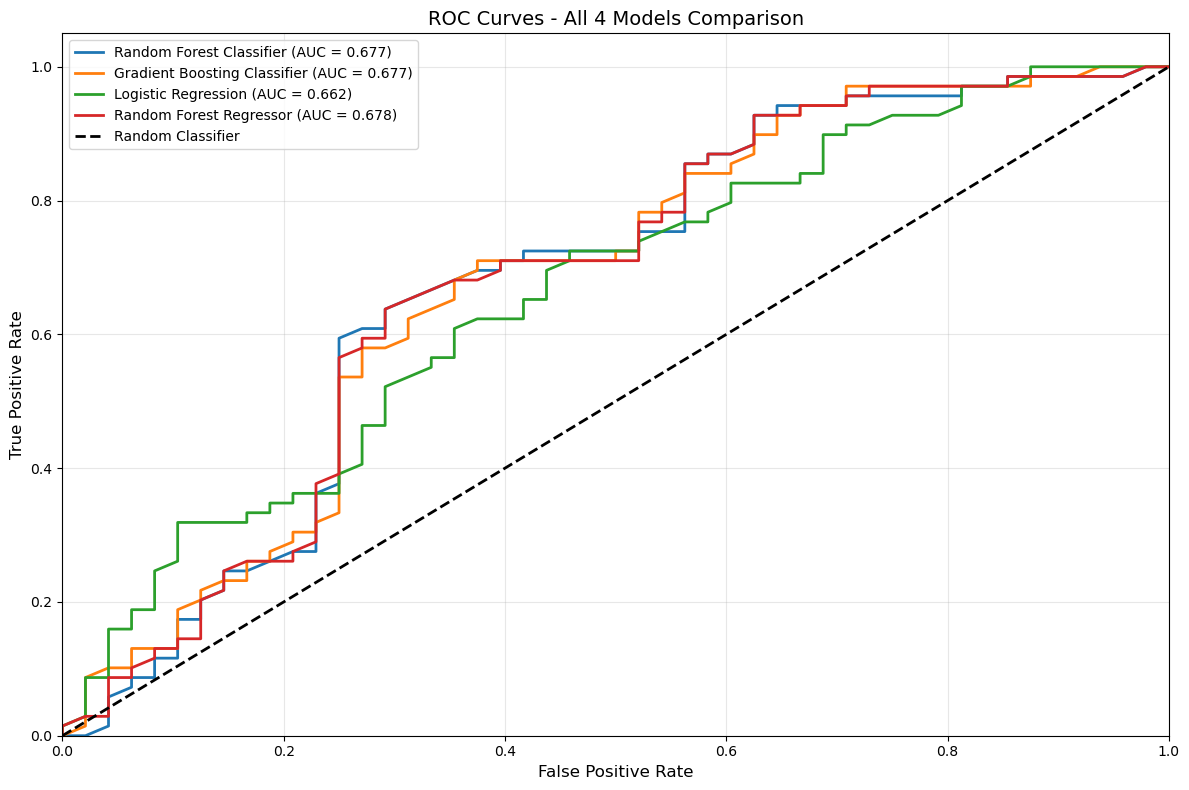

In [14]:
# ======================
# CELL 12: ROC CURVES VISUALIZATION
# ======================

print("\n8. ROC Curves Visualization - All 4 Models")
print("=" * 50)

plt.figure(figsize=(12, 8))

for model_name, results in validation_results.items():
    fpr, tpr, _ = roc_curve(y_val, results['probabilities'])
    auc_score = results['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All 4 Models Comparison', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# ======================
# CELL 13: SELECT BEST MODEL AND TEST EVALUATION
# ======================

print("\n9. Final Test Set Evaluation with Best Model")
print("=" * 50)

# Select best model based on validation accuracy
best_model_name = comparison_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"📊 Validation Accuracy: {comparison_df.iloc[0]['Validation Accuracy']:.3f}")
print(f"📈 Validation ROC-AUC: {comparison_df.iloc[0]['Validation ROC-AUC']:.3f}")

# Evaluate on test set
if 'Regressor' in best_model_name:
    y_test_pred_continuous = best_model.predict(X_test_imputed)
    y_test_pred = (y_test_pred_continuous > 0.5).astype(int)
    y_test_proba = y_test_pred_continuous
else:
    y_test_pred = best_model.predict(X_test_imputed)
    y_test_proba = best_model.predict_proba(X_test_imputed)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n🎯 FINAL TEST SET PERFORMANCE:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"ROC-AUC:  {test_auc:.3f}")


9. Final Test Set Evaluation with Best Model
🏆 BEST MODEL: Random Forest Classifier
📊 Validation Accuracy: 0.658
📈 Validation ROC-AUC: 0.677

🎯 FINAL TEST SET PERFORMANCE:
Accuracy: 0.585
ROC-AUC:  0.588
